In [1]:
from liquefaction import *
import plotly.express as px
import pygeos
from matplotlib_scalebar.scalebar import ScaleBar
import itertools


In [18]:
bldgs = pd.read_csv('./full_outputs/Pelicun_Alameda_Inventory.csv')
bldgs.keys()

imdir = './inputs/generate_IMs/'

import pyDGSA
from pyDGSA.dgsa import *
from pyDGSA.plot import *
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
from pyDGSA.cluster import *
import warnings
warnings.filterwarnings('ignore' )

In [4]:
# make a folder to save the figures
os.mkdir('./figures/')

In [22]:
# Plot parameters

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = ["Calibri"] + plt.rcParams['font.sans-serif']
plt.rcParams['figure.figsize'] = (11,8)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['font.size'] = 16

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

orig_cmap = plt.cm.Blues
cols = orig_cmap(np.linspace(0.2, 1, 10))
color = [[1,1,1,1]]
for i in range(len(cols)):
    color.append(list(cols[i]))
color.append([0,0,0,1])
color.append([0,0,0,1])

cmap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", color)

orig_cmap = plt.cm.Blues_r
color_R = orig_cmap(np.linspace(0.2, 1, 10))


In [6]:
# Load data from liquefaction outputs

outdir = './full_outputs/'
# edit depending on output files to be read #
gdfp1 = gpd.read_file(outdir + 'gdfp800.geojson')
gdfp2 = gpd.read_file(outdir + 'gdfp1600.geojson')
gdfp3 = gpd.read_file(outdir + 'gdfp2430.geojson')

gdfp1.drop(columns=['lat','lon'],inplace=True)
gdfp2.drop(columns=['lat','lon'],inplace=True)
gdfp3.drop(columns=['lat','lon'],inplace=True)

gdfp = gdfp1.merge(gdfp2, on='geometry')
gdfp = gdfp.merge(gdfp3, on='geometry')

In [7]:
output = gdfp.drop(['geometry'], axis = 1)
output = np.swapaxes(np.array(output),0,1)

nsim = output.shape[0]

### Postprocess

In [8]:
# ! pip install "pandas<2.0.0" --user

# This may be necessary to get pickle.load to work. 

In [9]:
# change file path if necessary
lambda_M = get_pM_pypsha('./inputs/generate_IMs/event_save.pickle')
pliq = get_pliq(output)

lambda_p = np.zeros(shape=pliq.shape)
temp = []
for i in range(nsim):
    lambda_m = lambda_M[i]
    temp.append(pliq[i,:]*lambda_m)
lambda_liq = sum(temp)

gdf_lam_liq = gpd.GeoDataFrame(lambda_liq,geometry=gdfp.geometry)
gdf_lam_liq.rename(columns = {0:'p'}, inplace = True)


In [10]:
RP = 1/lambda_liq
gdf_RP = gpd.GeoDataFrame(RP,geometry=gdfp.geometry)
gdf_RP.rename(columns = {0:'RP'}, inplace = True)
gdf_RP['lambda'] = lambda_liq

In [11]:
os.getcwd()

'c:\\Users\\Emily\\Documents\\GitHub\\liquefaction\\example'

meta NOT subset; don't know how to subset; dropped


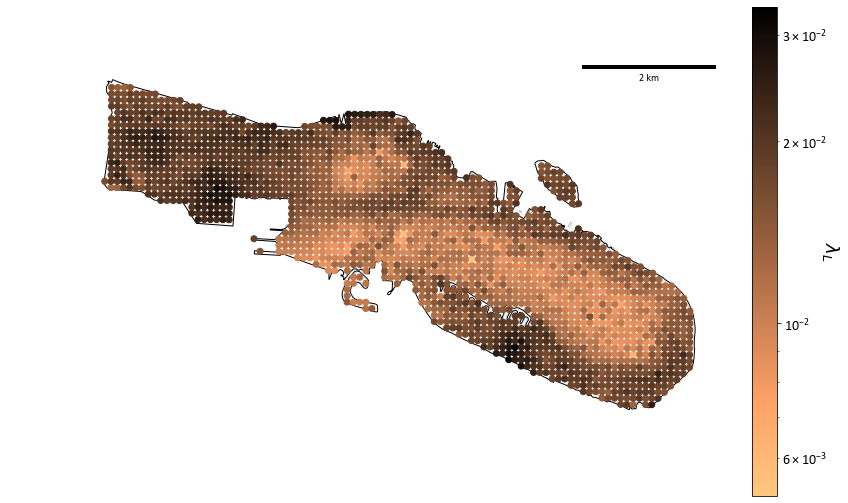

In [12]:
ax=Alameda_baseplot('../liquefaction/liquefaction/alameda_plots/')
gdf_RP.plot(ax=ax,zorder=3,cmap='copper_r',column='lambda',norm=mpl.colors.LogNorm(vmin=min(gdf_RP['lambda']),vmax=max(gdf_RP['lambda'])))
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=min(gdf_RP['lambda']),vmax=max(gdf_RP['lambda'])), \
                                          cmap='copper_r'), ax=ax,fraction=0.046, pad=0.04) 
cbar.ax.get_yaxis().labelpad = 14
cbar.ax.set_ylabel('$\lambda_{L}$', rotation=270)
ax.add_artist(ScaleBar(81540)) #distance in meters between one difference in longitude degrees
plt.savefig('figures/map_lambda_liq.pdf',bbox_inches='tight')

In [13]:
areas = np.linspace(0, 1, 10)
lpis = np.linspace(0, 20, 20)
X, Y = np.meshgrid(areas, lpis)

Z = np.zeros(shape=(len(areas),len(lpis)))
for ind,which in itertools.product(range(len(areas)), range(len(lpis))):
    area = areas[ind]
    lpi = lpis[which]
    temp = []
    for i in range(nsim): 
        temp.append(((sum(output[i,:] > lpi) / output.shape[1]) > area)*lambda_M[i])
    Z[ind,which] = sum(np.array(temp))
    

In [14]:
np.save(outdir + 'area_rate.npy',Z)
# Z = np.load(outdir + 'area_rate.npy')

meta NOT subset; don't know how to subset; dropped


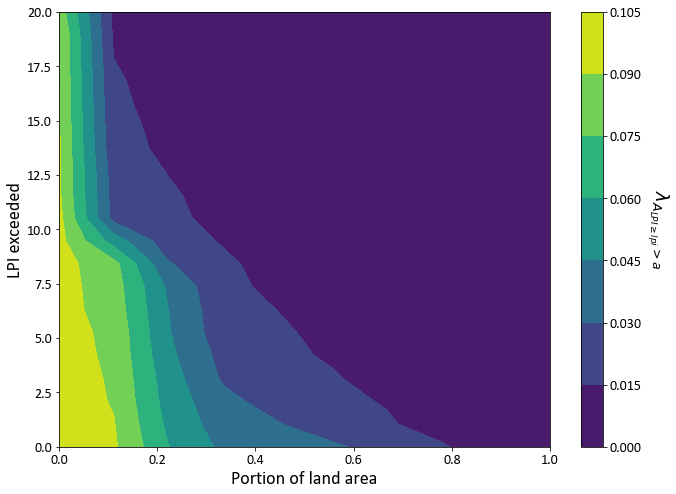

In [23]:
fig,ax=plt.subplots(1,1)
cp = ax.contourf(areas, lpis, Z.T)
cbar = fig.colorbar(cp)
cbar.ax.get_yaxis().labelpad = 28
cbar.ax.set_ylabel('$\lambda_{A_{LPI \geq lpi} > a}$', rotation=270)
ax.set_xlabel('Portion of land area')
ax.set_ylabel('LPI exceeded')
plt.savefig('figures/LPI-Area-Rate.pdf',bbox_inches='tight')
plt.show()

### Loss analysis

In [19]:
bldgs_gdf = gpd.GeoDataFrame(bldgs,geometry=gpd.points_from_xy(bldgs.Longitude,bldgs.Latitude))
bldgs_gdf.set_crs(epsg=4326,inplace=True)
Alameda = gpd.read_file('./inputs/alameda_plots/Alameda_shape.geojson')
bldgs = gpd.sjoin(bldgs_gdf,Alameda)
bldgs.reset_index(inplace=True,drop=True)
bldgs = bldgs.drop(['index_right'], axis=1)


In [20]:
def geyin_ff(LPI):
    # calculates the loss ratio from LPI based on Geyin et al. 2020
    loss_ratio = 0.11668 * (LPI**0.4607)
    return loss_ratio


def frag_func(LPI):
    # calculates fragility function for a 2D input of LPI values
    # inputs: array of LPIs
    # outputs: array of loss_ratios
        
    loss_ratio = []
    for i in range(LPI.shape[0]):
        temp = list(map(lambda x:geyin_ff(x),LPI[i]))
        loss_ratio.append(temp)
    loss_ratio = np.array(loss_ratio)
    
    return loss_ratio
    

This section of code runs the loss analysis

In [25]:
bldPGA = np.load(outdir + 'bldPGA.npy')

cl = [ca_cl(year) for year in bldgs['YearBuilt']]
STR = [type_year(oc, year) for oc, year in zip(bldgs['OccupancyClass'], bldgs['YearBuilt'])]
beta = 0.64
theta = np.array([get_theta(s, c) for s, c in zip(STR, cl)])

LR_eq = np.zeros(shape=bldPGA.shape)

pgas = np.swapaxes(np.tile(bldPGA.T,(4,1,1)),0,-1)
theta1 = np.tile(theta,(len(bldPGA),1,1))

cdf = stats.lognorm(s=beta, scale=theta1).cdf(pgas)
pdf = np.concatenate((np.ones((cdf.shape[0], cdf.shape[1], 1)), cdf), axis=2) - np.concatenate((cdf, np.zeros((cdf.shape[0], cdf.shape[1], 1))), axis=2) 


index = pd.MultiIndex.from_product([range(s) for s in pdf.shape],names=['sim','bld','ds'])
df = pd.DataFrame({'A':pdf.flatten()},index=index)['A']
df = df.unstack(level='ds').swaplevel().sort_index()

states = [0,1,2,3,4]
rng = np.random.default_rng(42)
df_selections = pd.DataFrame(data = rng.multinomial(n=1,pvals=df.to_numpy()),columns=states,index=df.index)
DS = df_selections.idxmax(axis=1)

In [52]:
LR_df = loss_from_damage(DS)
m,n = len(LR_df.index.levels[0]), len(LR_df.index.levels[1])
LR_eq = LR_df.values.reshape(m,n,-1).swapaxes(0,1)
LR_eq = np.squeeze(LR_eq)

In [53]:
bldLPI = np.load(outdir + 'bldLPI.npy')

LR_liq = frag_func(bldLPI)

LR = np.maximum(LR_eq,LR_liq)
LR.shape

(2430, 12377)

In [54]:
LR_both = LR.clip(max=1)

bldg_losses = []

for sim in range(LR_both.shape[0]):
    temp = LR_both[sim,:] * bldgs['ReplacementCost']
    bldg_losses.append(temp)
bldg_losses = np.array(bldg_losses)


reg_losses = sum(bldg_losses.T)
reg_losses.shape

(2430,)

In [55]:
lambda_M = np.array(get_pM_pypsha(imdir + 'event_save.pickle')) # from pypsha
weighted_losses = lambda_M * reg_losses
E_loss = sum(weighted_losses)
np.round(E_loss)

bldg_eal = lambda_M * bldg_losses.T
bldgs['EAL'] = np.sum(bldg_eal,1)
bldgs['EAL_norm'] = bldgs['EAL']/bldgs['ReplacementCost']

In [29]:
LR.shape

(2430, 12377)

In [56]:
E_LR = np.sum(lambda_M*LR.T,1)
E_LRliq = np.sum(lambda_M*LR_liq.T,1)

bldgs['E_LR'] = E_LR
bldgs['LR_liq_norm'] = E_LRliq / E_LR

meta NOT subset; don't know how to subset; dropped


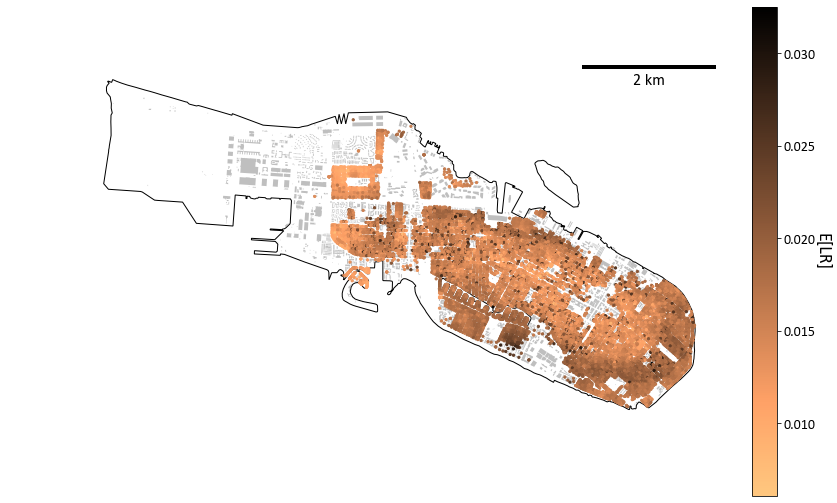

In [57]:
ax=Alameda_baseplot('../liquefaction/liquefaction/alameda_plots/')
bldgs.plot(ax=ax,zorder=3,markersize=5,cmap='copper_r',column='E_LR',norm=mpl.colors.Normalize(vmin=min(bldgs['E_LR']),vmax=max(bldgs['E_LR'])))
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(bldgs['E_LR']),vmax=max(bldgs['E_LR'])), \
                                          cmap='copper_r'), ax=ax,fraction=0.046, pad=0.04) 
cbar.ax.get_yaxis().labelpad = 14
cbar.ax.set_ylabel('E[LR]', rotation=270)
ax.add_artist(ScaleBar(81540)) #distance in meters between one difference in longitude degrees

plt.savefig('figures/map_bldg_LR.pdf',bbox_inches='tight')


meta NOT subset; don't know how to subset; dropped


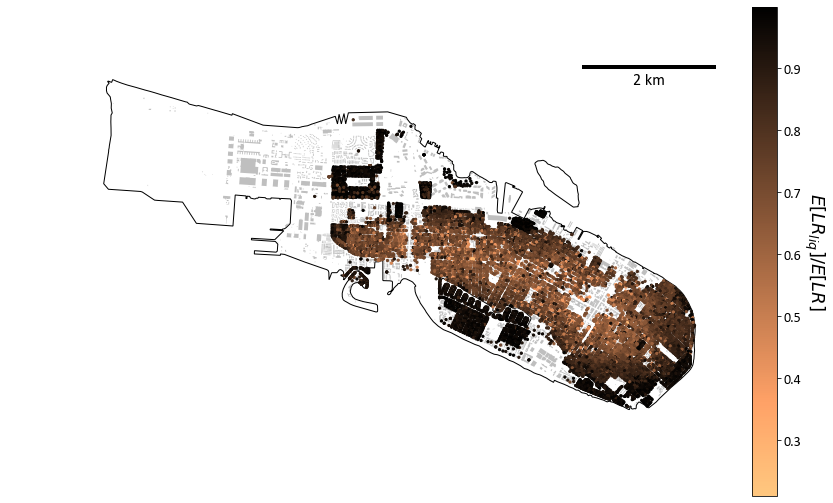

In [58]:
ax=Alameda_baseplot('../liquefaction/liquefaction/alameda_plots/')
bldgs.plot(ax=ax,zorder=3,markersize=5,cmap='copper_r',column='LR_liq_norm',norm=mpl.colors.Normalize(vmin=min(bldgs['LR_liq_norm']),vmax=max(bldgs['LR_liq_norm'])))
cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(bldgs['LR_liq_norm']),vmax=max(bldgs['LR_liq_norm'])), \
                                          cmap='copper_r'), ax=ax,fraction=0.046, pad=0.04) 
cbar.ax.get_yaxis().labelpad = 24
cbar.ax.set_ylabel('$E[LR_{liq}]/E[LR]$', rotation=270)
ax.add_artist(ScaleBar(81540)) #distance in meters between one difference in longitude degrees

plt.savefig('figures/map_norm_EliqLR.pdf',bbox_inches='tight')


##### Exceedance curves

In [66]:
loss = np.sum(np.array(bldgs['ReplacementCost'])*LR_both,1)
loss_eq = np.sum(np.array(bldgs['ReplacementCost'])*LR_eq,1)
loss_liq = np.sum(np.array(bldgs['ReplacementCost'])*LR_liq,1)

loss_thresholds = range(round(min(loss_liq)),round(max(loss)),10**5)  #This threshold is small because the building values are all 1000
exceed = []
exceedeq = []
exceedliq = []
for thresh in loss_thresholds:
    exceed.append(np.sum(lambda_M*(loss>=thresh)))
    exceedeq.append(np.sum(lambda_M*(loss_eq>=thresh)))
    exceedliq.append(np.sum(lambda_M*(loss_liq>=thresh)))


In [67]:
HH = np.zeros(len(lambda_M))
HHeq = np.zeros(len(lambda_M))
HHliq = np.zeros(len(lambda_M))
for i in range(len(lambda_M)):
    HH[i] = sum(LR_both[i,:]>=0.5)/np.shape(LR)[1]
    HHeq[i] = sum(LR_eq[i,:]>=0.5)/np.shape(LR)[1]
    HHliq[i] = sum(LR_liq[i,:]>=0.5)/np.shape(LR)[1]
hh = []
hheq = []
hhliq = []
hh_thresholds = np.linspace(0,1,10)
for thresh in hh_thresholds:
    hh.append(np.sum(lambda_M*(HH>=thresh)))
    hheq.append(np.sum(lambda_M*(HHeq>=thresh)))
    hhliq.append(np.sum(lambda_M*(HHliq>=thresh)))


meta NOT subset; don't know how to subset; dropped


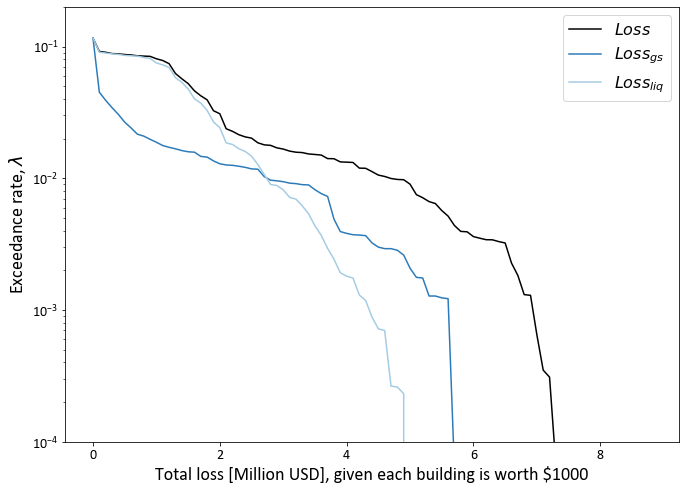

In [68]:
loss_plot = np.array(list(loss_thresholds))/1e6
plt.semilogy(loss_plot,exceed,c='k')
plt.semilogy(loss_plot,exceedeq,c=color_R[1])
plt.semilogy(loss_plot,exceedliq,c=color_R[5])
plt.legend(['$Loss$','$Loss_{gs}$','$Loss_{liq}$'])
plt.ylim([1e-4,0.2])
plt.ylabel('Exceedance rate, $ \\lambda$')
plt.xlabel('Total loss [Million USD], given each building is worth $1000')
plt.savefig('./figures/exceedance_loss_compare.pdf',bbox_inches='tight')

### Sensitivity analysis

##### Run this section if you have performed a new run

In [70]:
# gmm = np.loadtxt(outdir + 'gmm.csv')
# pga = pd.read_csv(outdir + 'pgas.csv')
# pga.drop(['Unnamed: 0'],axis=1,inplace=True)

# fun = np.loadtxt(outdir + 'fun.csv', delimiter=",")
# C_FC = np.loadtxt(outdir + 'cfc.csv', delimiter=",")
# wd = np.loadtxt(outdir + 'wd.csv', delimiter=",")

# nug = np.loadtxt(outdir + 'nugget.csv', delimiter=",")
# rangemaj = np.loadtxt(outdir + 'range_maj.csv', delimiter=",")
# rangemin = np.loadtxt(outdir + 'range_min.csv', delimiter=",")

# nsim = output.shape[0]

In [ ]:
# param_names = ['Ground motion model','Water depth','Fines content','Variogram major range',
#                'Variogram minor range','Variogram nugget','Liquefaction equation']
# params = np.zeros(shape=(len(gmm),7))
# params[:,0] = gmm
# params[:,1] = wd
# params[:,2] = C_FC
# params[:,3] = rangemaj[0:len(gmm)]
# params[:,4] = rangemin[0:len(gmm)]
# params[:,5] = nug[0:len(gmm)]
# params[:,6] = fun

# params.shape

In [72]:
# out = np.zeros(shape=(len(output),3))
# for j in range(len(output)):
#     i = output[j]
#     sev = sum(i>15)
#     med = sum(i>5) - sev
#     none = len(i) - sev - med
#     out[j,:] = [none, med, sev]
    
# out = out/output.shape[1]

In [ ]:
# n_clust = 3

# distances = pdist(output, metric='euclidean')
# distances = squareform(distances)
# clusterer = KMedoids(n_clusters=n_clust,max_iter=2000,tol=1e-4)
# labels = clusterer.fit_predict(distances)
# distances.shape

In [ ]:
# low_avg = np.mean(output[labels==0])
# med_avg = np.mean(output[labels==1])
# high_avg = np.mean(output[labels==2])  # ,0 if running with out
# print('Low:',low_avg)
# print('Med:',med_avg)
# print('High:',high_avg)

In [ ]:
# cluster_names = ['Low cluster', 'Medium cluster', 'High cluster']

In [ ]:
# mean_sensitivity = dgsa(params,labels,parameter_names=param_names,quantile=0.5,n_boots=4000)
# cluster_sensitivity = dgsa(params, labels, parameter_names=param_names, 
#                            output='cluster_avg', cluster_names=cluster_names)
# mean_interact_sensitivity = dgsa_interactions(params, labels, parameter_names = param_names)
# cluster_interact_sensitivity = dgsa_interactions(params, labels, parameter_names=param_names,
#                                                  cluster_names=cluster_names, output='cluster_avg')

# raw_interact_sensitivity = dgsa_interactions(params, labels, parameter_names=param_names,
#                                              cluster_names=cluster_names, output='indiv')

In [77]:
def vert_pareto_plot(df, np_plot='+5', fmt=None, colors=None, confidence=False,
                     figsize=None):
    """Generate a vertical Pareto plot of sensitivity analysis results.
    
    params:
        df [DataFrame]: pandas dataframe containing the sensitivity analysis
                results. If fmt == 'max' or 'mean', df contains a single column
                with indices correspond to the parameters. If fmt == 'cluster_avg', 
                the columns of df correspond to the number of clusters and 
                the rows correspond to the parameters.
        np_plot [str|int]: number of parameters to plot. Default: '+5'
                -'all': plot all parameters
                -n: plot n parameters, where n is an int
                -'+n': plot all parameters with sensitivity >1, plus 
                       the n next most sensitive parameters
        fmt [str]: format of df. Optional, will interpret fmt based on df shape
                -'mean': single sensitivity was passed per param, therefore
                         display a single bar per param
                -'max': same as 'mean'
                -'cluster_avg': cluster-specific sensitivities were passed, so
                            display cluster's sensitivity separately
                -'bin_avg': bin-specific sensitivities were passed, so display
                            each bin's sensitivity separately
                -'indiv': plots the sensitivity for each bin/cluster combination
                        separately
        confidence [bool]: whether or not to plot confidence bars. Default is False, 
                but must be included in df if confidence == True.
        colors [list(str|int)]: list of clusters colors to use when plotting, 
                either specified as rgba tuples or strings of matplotlib named 
                colors. Only used when fmt='cluster_avg' or 'indiv'
   
    returns:
        fig: matplotlib figure handle
        ax: matplotlib axis handle
    """
    
    # Total np (number of parameters)
    np_total = df.shape[0] 
    
    # Figure out fmt if not explicitly provided
    if fmt is None:
        if isinstance(df.columns, pd.MultiIndex):
            fmt = 'indiv'
        elif df.shape[1] > 1 and 'confidence' not in df.columns:
            # Could be either 'cluster_avg' or 'bin_avg'
            if 'Cluster' in df.columns[0]:
                fmt = 'cluster_avg'
            elif 'Bin' in df.columns[0]:
                fmt = 'bin_avg'
            else:
                raise ValueError("Could not determine fmt. Please pass explicitly.")
        else:
            # Note that 'mean' also includes 'max' format from the analysis
            fmt = 'mean'
            if 'confidence' in df.columns:
                cdf = df['confidence'].copy()
                # copy to avoid altering input df
                df = df.drop('confidence', axis=1).copy() 
    
    if fmt == 'indiv' and colors is not None:
        if isinstance(colors[0], str):
            # Convert named colors to rgba
            named_colors = colors
            colors=[]
            for color in named_colors:
                colors.append(matplotlib.colors.to_rgba(color))
        
    if fmt == 'cluster_avg':
        # Check if confidence bounds were provided by counting 
        # columns that end with "_conf"
        conf_cols = [col for col in df.columns if col[-5:] == '_conf']
        if len(conf_cols) > 0:
            cdf = df[conf_cols].copy()
            df = df.drop(conf_cols, axis=1).copy()
            
    # Get number of parameters with sensitivity >= 1
    np_sensitive = np.any((df.fillna(0).values >= 1), axis=1).sum()

    # Figure out how many parameters to plot
    if isinstance(np_plot, str):
        if np_plot == 'all':
            np_max_plot = np_total
        elif np_plot[0] == '+':
            np_max_plot = np_sensitive + int(np_plot[1:])
        else:
            raise ValueError("np_plot must be 'all', 'n', or '+n', where n is an int")
    elif isinstance(np_plot, int):
        np_max_plot = np_plot

    # Ensure that requested # of params to plot is not larger than total # of params
    if np_max_plot > np_total:
        np_max_plot = np_total

    # Y-position of bars
    y_pos = np.arange(np_max_plot)
    
    if fmt == 'mean' or fmt == 'max':
        # Sort so most sensitive params are on top
        df.sort_values(by=df.columns[0], ascending=False, inplace=True)
        data = df.values[:np_max_plot, :].squeeze()
        params = df.index.tolist() # Get list of params after sorting
        
        yticks = y_pos 

        # Error bars (confidence interval); by default these are plotted, but of 
        # length 0 if confidence == False
        if confidence:
            xerr = cdf[df.index[:np_max_plot]].values/2
        else:
            xerr = 0

        # Values are color-coded. If confidence intervals are provided
#         if confidence:
#             colors = np.asarray([[1, 1, 1, 0.8]]*np_max_plot)
#             # > confidence interval red
#             colors[data - xerr > 1] = [1, 0, 0, 0.8]
#             # < confidence interval blue
#             colors[data + xerr < 1] = [0, 0, 1, 0.8]
#         else:
#             if np_sensitive > 0:
#                 colors = np.asarray([[1, 0, 0, 0.8]]*np_max_plot)
#             else:
#                 colors = np.asarray([[0, 0, 1, 0.8]]*np_max_plot)

#             if np_max_plot > np_sensitive:
#                 if np_sensitive > 0:
#                     colors[np_sensitive] = [1, 1, 1, 1]
#                 colors[np_sensitive+1:] = [0, 0, 1, 0.8] 

        if figsize is None:
            fig_height = int(np_max_plot/2)
            figsize = (5, fig_height)

        # Create figure and add barh
        fig, ax = plt.subplots(figsize=figsize)
        ax.barh(y_pos, data, color=colors, edgecolor='k', xerr=xerr) 

    elif fmt == 'cluster_avg':
        n_clusters = df.shape[1]
        
        # Sort by mean sensitivity across clusters 
        sort_df = df.mean(axis=1).sort_values(ascending=False)
        df = df.reindex(sort_df.index)
        params = df.index.tolist() # Get list of params after sorting
        
        # Add error bars if confidence=True, otherwise set length to 0
        if confidence:
            xerr = cdf.loc[df.index, :].values
        else:
            xerr = df.loc[df.index, :].values*0
        
        height = 1/(n_clusters+1)
        yticks = y_pos - (height*(n_clusters-1)/2)
        
        if colors is None:
            colors = []
            cmap = matplotlib.cm.get_cmap('Set1')
            for i in range(n_clusters):
                colors.append(cmap(i))

        # Create figure
        if figsize is None:
            fig_height = int(np_max_plot/2*1.5)
            figsize = (5, fig_height)
            
        fig, ax = plt.subplots(figsize=figsize)

        # Add bars for each cluster
        for i in range(n_clusters):
            ax.barh(y_pos - height*i, df.iloc[:np_max_plot, i], height=height, 
                    color=colors[i], edgecolor='k', label=df.columns.tolist()[i],
                    xerr=xerr[:np_max_plot, i])
        ax.legend()
        
    elif fmt == 'bin_avg':
        n_bins = df.shape[1]
        
        # Sort by mean sensitivity across bins 
        sort_df = df.mean(axis=1).sort_values(ascending=False)
        df = df.reindex(sort_df.index)
        params = df.index.tolist()

        yticks = y_pos

        if colors is None:
            cmap = matplotlib.cm.get_cmap('Set1')
            colors = cmap(1)

        # Create color array by decreasing alpha channel for each bin
        color_array = np.tile(colors, (n_bins, 1))
        for i in range(n_bins):
            color_array[i, 3] = (i+1)/(n_bins)

        if figsize is None:
            fig_height = int(np_max_plot/2*1.5)
            figsize = (5, fig_height)
            
        fig, ax = plt.subplots(figsize=figsize)

        for i in range(n_bins):
            width = df.iloc[:np_max_plot, i]
            left = df.iloc[:np_max_plot, :i].sum(axis=1)
            b = ax.barh(y_pos, width=width, left=left, color=color_array[i], 
                        edgecolor='k')
                
            # Increase linewidth for parameters that are sensitive
            for w in enumerate(width.tolist()):
                if w[1] > 1:
                    b[w[0]].set_linewidth(2.5)
        
    elif fmt == 'indiv':
        n_clusters, n_bins = df.columns.levshape
        
        # Split df into sensitive and non-sensitive df's, sort each, then re-combine
        # Can't just sort on mean sensitivity, otherwise a sensitive parameter
        # could get left out because its mean might not be within the top 
        # np_max_plot most sensitive, even though a single bin is >= 1
        mask = np.any((df.fillna(0).values >= 1), axis=1)
        sens = df[mask].copy()
        nsens = df[~mask].copy()
        sort_sens = sens.mean(axis=1).sort_values(ascending=False)
        sens = sens.reindex(sort_sens.index)
        sort_nsens = nsens.mean(axis=1).sort_values(ascending=False)
        nsens = nsens.reindex(sort_nsens.index)
        df = sens.append(nsens)

        params = df.index.tolist()
        df.fillna(0, inplace=True)
        height = 1/(n_clusters+1)
        yticks = y_pos - (height*(n_clusters-1)/2)

        if colors is None:
            cmap = matplotlib.cm.get_cmap('Set1')
            colors = []
            for i in range(n_clusters):
                colors.append(cmap(i))

        idx = pd.IndexSlice
                
        # Create color array by decreasing alpha channel for each bin
        color_array = np.zeros((n_clusters, n_bins, 4), dtype='float64')
        for i in range(n_clusters):
            for j in range(n_bins):
                color_array[i, j, :] = colors[i]
                color_array[i, j, 3] = (j+1)/(n_bins)

        fig_height = int(np_max_plot/2*1.5)
        fig, ax = plt.subplots(figsize=(5, fig_height))

        for i in range(n_clusters):
            for j in range(n_bins):
                col_idx = i*n_bins + j
                width = df.iloc[:np_max_plot, col_idx]
                left = df.iloc[:np_max_plot, n_bins*i:col_idx+1].sum(axis=1) - width
                y = y_pos - height*i
                if j == n_bins - 1:
                    # Add label to last bin
                    b = ax.barh(y, width=width, height=height, left=left, 
                                color=color_array[i, j], edgecolor='k', 
                                label=df.columns.tolist()[i*n_bins][0])
                else:
                    b = ax.barh(y, width=width, height=height, left=left, 
                                color=color_array[i, j], edgecolor='k')
                    
                # Increase linewidth for parameters that are sensitive
                for w in enumerate(width.tolist()):
                    if w[1] > 1:
                        b[w[0]].set_linewidth(2.5)
        
        leg = ax.legend()
        # Ensure that linewidths in the legend are all 1.0 pt
        for legobj in leg.legendHandles:
            legobj.set_linewidth(1)

    # Add vertical line and tick labels
    if fmt not in ['indiv', 'bin_avg']:
        ax.axvline(1, color='k', linestyle='--')
    ax.set(yticks=yticks, yticklabels=params[:np_max_plot], xlabel='Sensitivity')
    ax.invert_yaxis()
    
    # Move xaxis label and ticks to top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
        
    return fig, ax


In [ ]:
# fig, ax = vert_pareto_plot(mean_sensitivity, np_plot='+4',colors=color_R) 
# plt.savefig('figures/sensitivity1.pdf',bbox_inches='tight')

##### Load saved sensitivity data

In [81]:
with open('./full_outputs/sensitivity_save.pickle', 'rb') as handle:
    output_sens = pickle.load(handle)

In [82]:
param_names = ['Ground motion model','Water depth','Fines content','Variogram major range',
               'Variogram minor range','Variogram nugget','Liquefaction equation']
# change row names within output_sens[4]['mean_sensitivity'] to param_names
for i in output_sens.keys():
    output_sens[i]['mean_sensitivity'] = output_sens[i]['mean_sensitivity'].iloc[7:,1:]

meta NOT subset; don't know how to subset; dropped


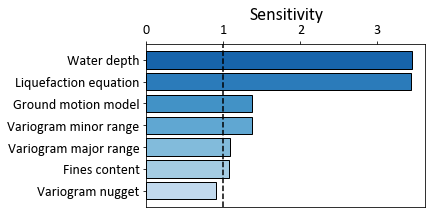

In [83]:
fig, ax = vert_pareto_plot(pd.DataFrame(output_sens[3]['avg_mean_sens'],index=param_names), np_plot='+4',colors=color_R)#,figsize=(11,8))
plt.savefig('figures/sensitivity1.pdf',bbox_inches='tight')

### Disaggregation

In [84]:
output = np.array(gdfp.drop(['geometry'],axis=1))

with open(imdir + 'event_save.pickle', 'rb') as j:
    event_set = pickle.load(j)

In [85]:
[item[:-4] for item in list(event_set.events.intensity_filelist['filename'])]

['ASK2014_PGA', 'BSSA2014_PGA', 'CY2014_PGA']

In [86]:
rate = np.array(event_set.events.metadata['annualized_rate'])
mag = np.array(event_set.events.metadata['magnitude'])
dist = np.average(np.genfromtxt(imdir + 'rup_dist_info.txt')[:,2:],1)
rup = event_set.events.metadata['name']

mean_rup_dists = pd.DataFrame()
mean_rup_dists['Rate'] = rate
mean_rup_dists['Magnitude'] = mag
mean_rup_dists['Distance'] = dist
# mean_rup_dists['name'] = rup

#### Disagg setup

In [87]:
dists = sorted(mean_rup_dists['Distance'].unique())
lows = range(0,200,10)
highs = range(10,210,10)
lower = [5,5.5,6,6.5,7,7.5,8]
upper = [5.5,6,6.5,7,7.5,8,8.5]

In [88]:
lpi5 = sum(output > 5)/len(output)
lpi10 = sum(output > 10)/len(output)
lpi15 = sum(output > 15)/len(output)  # number of locations for each scneario that is above given LPI divided by total number of locations


# Portions of area exceeding each LPI thresholds
a40lpi5 = (lpi5>0.4) * mean_rup_dists['Rate']
a40lpi15 = (lpi15>0.4) * mean_rup_dists['Rate']
a20lpi5 = (lpi5>0.2) * mean_rup_dists['Rate']
a20lpi15 = (lpi15>0.2) * mean_rup_dists['Rate']

a25lpi5 = (lpi5>0.25) * mean_rup_dists['Rate']
a25lpi10 = (lpi10>0.25) * mean_rup_dists['Rate']
a50lpi5 = (lpi5>0.5) * mean_rup_dists['Rate']
a50lpi10 = (lpi10>0.5) * mean_rup_dists['Rate']


In [89]:
deag40_5 = np.zeros(shape=(len(lower),len(lows)))
deag40_15 = np.zeros(shape=(len(lower),len(lows)))
deag20_5 = np.zeros(shape=(len(lower),len(lows)))
deag20_15 = np.zeros(shape=(len(lower),len(lows)))

deag25_5 = np.zeros(shape=(len(lower),len(lows)))
deag25_10 = np.zeros(shape=(len(lower),len(lows)))
deag50_5 = np.zeros(shape=(len(lower),len(lows)))
deag50_10 = np.zeros(shape=(len(lower),len(lows)))
x = []
y = []

for i in range(len(lower)):
    for j in range(len(lows)):
        x.append(lower[i])
        y.append(lows[j])
        deag50_5[i,j] = np.sum(a50lpi5*((mean_rup_dists['Magnitude'] >= lower[i]) & (mean_rup_dists['Magnitude'] < upper[i]))*((mean_rup_dists['Distance'] >= lows[j]) & (mean_rup_dists['Distance'] < highs[j]))/sum(a50lpi5))
        deag50_10[i,j] = np.sum(a50lpi10*((mean_rup_dists['Magnitude'] >= lower[i]) & (mean_rup_dists['Magnitude'] < upper[i]))*((mean_rup_dists['Distance'] >= lows[j]) & (mean_rup_dists['Distance'] < highs[j]))/sum(a50lpi10))
        deag25_5[i,j] = np.sum(a25lpi5*((mean_rup_dists['Magnitude'] >= lower[i]) & (mean_rup_dists['Magnitude'] < upper[i]))*((mean_rup_dists['Distance'] >= lows[j]) & (mean_rup_dists['Distance'] < highs[j]))/sum(a25lpi5))
        deag25_10[i,j] = np.sum(a25lpi10*((mean_rup_dists['Magnitude'] >= lower[i]) & (mean_rup_dists['Magnitude'] < upper[i]))*((mean_rup_dists['Distance'] >= lows[j]) & (mean_rup_dists['Distance'] < highs[j]))/sum(a25lpi10))
        deag20_5[i,j] = np.sum(a20lpi5*((mean_rup_dists['Magnitude'] >= lower[i]) & (mean_rup_dists['Magnitude'] < upper[i]))*((mean_rup_dists['Distance'] >= lows[j]) & (mean_rup_dists['Distance'] < highs[j]))/sum(a20lpi5))
        deag20_15[i,j] = np.sum(a20lpi15*((mean_rup_dists['Magnitude'] >= lower[i]) & (mean_rup_dists['Magnitude'] < upper[i]))*((mean_rup_dists['Distance'] >= lows[j]) & (mean_rup_dists['Distance'] < highs[j]))/sum(a20lpi15))
        deag40_5[i,j] = np.sum(a40lpi5*((mean_rup_dists['Magnitude'] >= lower[i]) & (mean_rup_dists['Magnitude'] < upper[i]))*((mean_rup_dists['Distance'] >= lows[j]) & (mean_rup_dists['Distance'] < highs[j]))/sum(a40lpi5))
        deag40_15[i,j] = np.sum(a40lpi15*((mean_rup_dists['Magnitude'] >= lower[i]) & (mean_rup_dists['Magnitude'] < upper[i]))*((mean_rup_dists['Distance'] >= lows[j]) & (mean_rup_dists['Distance'] < highs[j]))/sum(a40lpi15))

#### Main disagg figs

meta NOT subset; don't know how to subset; dropped


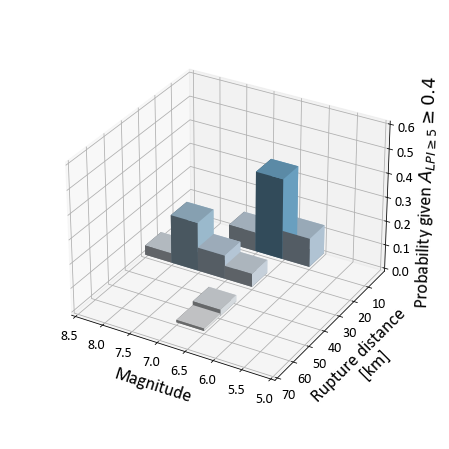

In [90]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.dist = 12

plot_deag40_5 = deag40_5.reshape(deag40_5.shape[0]*deag40_5.shape[1])
plot_x = np.array(x)[np.where(plot_deag40_5>=0.01)] # changed from != 0
plot_y = np.array(y)[np.where(plot_deag40_5>=0.01)]
plot_deag40_5 = plot_deag40_5[plot_deag40_5>=0.01]
a = np.ones(len(plot_x))
dx = a*0.5
dy = a*10
ax.bar3d(plot_x,plot_y,np.zeros(len(plot_deag40_5)),dx,dy,plot_deag40_5,color = cmap(plot_deag40_5))
ax.set_xlabel('Magnitude', labelpad=12)
ax.set_ylabel('Rupture distance \n [km]', labelpad=18)
ax.set_zlabel('Probability given $A_{LPI \geq 5} \geq 0.4$',labelpad=8)
ax.set_ylim([70,0])
ax.set_zlim([0,0.6])
ax.set_yticks(highs[:7])
ax.set_xlim([8.5,5])
# plt.title('50% area with LPI > 5')
plt.savefig('figures/3d_deag_40_5.pdf',bbox_inches='tight')

meta NOT subset; don't know how to subset; dropped


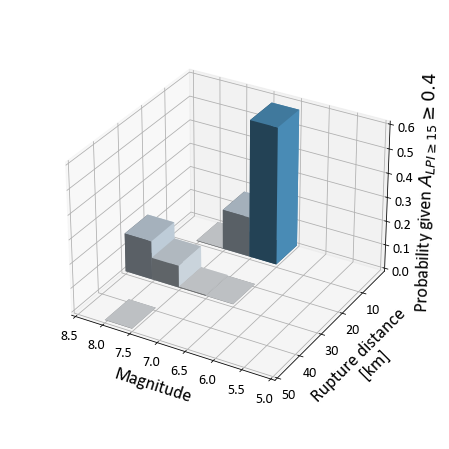

In [91]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.dist = 12

plot_deag40_15 = deag40_15.reshape(deag40_15.shape[0]*deag40_15.shape[1])
plot_x = np.array(x)[np.where(plot_deag40_15!=0)]
plot_y = np.array(y)[np.where(plot_deag40_15!=0)]
plot_deag40_15 = plot_deag40_15[plot_deag40_15!=0]
a = np.ones(len(plot_x))
dx = a*0.5
dy = a*10
ax.bar3d(plot_x,plot_y,np.zeros(len(plot_deag40_15)),dx,dy,plot_deag40_15,color = plt.cm.Blues(plot_deag40_15))  #cmap
ax.set_xlabel('Magnitude', labelpad = 12) # make the gap between the label and the axis larger
ax.set_ylabel('Rupture distance \n [km]', labelpad=18)
ax.set_zlabel('Probability given $A_{LPI \geq 15} \geq 0.4$', labelpad = 8)
ax.set_ylim([50,0])
ax.set_zlim([0,0.6])
ax.set_yticks(highs[:5])
ax.set_xlim([8.5,5])
plt.savefig('figures/3d_deag_40_15.pdf',bbox_inches='tight')

In [92]:
# reset bounds for remaining disaggregation calcs
lows1 = range(0,200,20)
highs1 = range(20,220,20)

x1 = []
y1 = []
deag20_51 = np.zeros(shape=(len(lower),len(lows1)))
deag40_51 = np.zeros(shape=(len(lower),len(lows1)))

for i in range(len(lower)):
    for j in range(len(lows1)):
        x1.append(lower[i])
        y1.append(lows1[j])
        deag20_51[i,j] = np.sum(a20lpi5*((mean_rup_dists['Magnitude'] >= lower[i]) & (mean_rup_dists['Magnitude'] < upper[i]))*((mean_rup_dists['Distance'] >= lows1[j]) & (mean_rup_dists['Distance'] < highs1[j]))/sum(a20lpi5))
        deag40_51[i,j] = np.sum(a40lpi5*((mean_rup_dists['Magnitude'] >= lower[i]) & (mean_rup_dists['Magnitude'] < upper[i]))*((mean_rup_dists['Distance'] >= lows1[j]) & (mean_rup_dists['Distance'] < highs1[j]))/sum(a40lpi5))

meta NOT subset; don't know how to subset; dropped


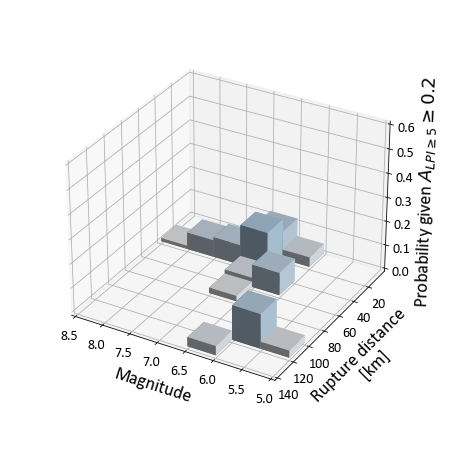

In [93]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.dist = 12

plot_deag20_5 = deag20_51.reshape(deag20_51.shape[0]*deag20_51.shape[1])
plot_x = np.array(x1)[np.where(plot_deag20_5>=0.01)]
plot_y = np.array(y1)[np.where(plot_deag20_5>=0.01)]
plot_deag20_5 = plot_deag20_5[plot_deag20_5>=0.01]
a = np.ones(len(plot_x))
dx = a*0.5
dy = a*20
ax.bar3d(plot_x,plot_y,np.zeros(len(plot_deag20_5)),dx,dy,plot_deag20_5,color = cmap(plot_deag20_5))
ax.set_xlabel('Magnitude', labelpad = 12)
ax.set_ylabel('Rupture distance \n [km]', labelpad = 18)
ax.set_zlabel('Probability given $A_{LPI \geq 5} \geq 0.2$', labelpad = 8)
ax.set_ylim([140,0])
ax.set_zlim([0,0.6])
ax.set_yticks(highs1[:7])
ax.set_xlim([8.5,5])
# plt.title('20% area with LPI > 5')
plt.savefig('figures/3d_deag_20_5_new.pdf',bbox_inches='tight')

meta NOT subset; don't know how to subset; dropped


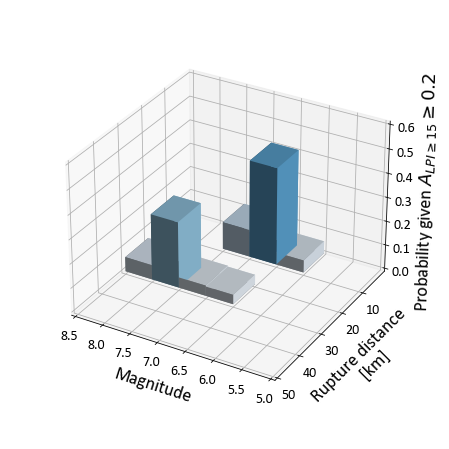

In [94]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.dist = 12

plot_deag20_15 = deag20_15.reshape(deag20_15.shape[0]*deag20_15.shape[1])
plot_x = np.array(x)[np.where(plot_deag20_15>=0.01)]
plot_y = np.array(y)[np.where(plot_deag20_15>=0.01)]
plot_deag20_15 = plot_deag20_15[plot_deag20_15>=0.01]
a = np.ones(len(plot_x))
dx = a*0.5
dy = a*10
ax.bar3d(plot_x,plot_y,np.zeros(len(plot_deag20_15)),dx,dy,plot_deag20_15,color = cmap(plot_deag20_15))
ax.set_xlabel('Magnitude', labelpad=12)
ax.set_ylabel('Rupture distance \n [km]',labelpad=18)
ax.set_zlabel('Probability given $A_{LPI \geq 15} \geq 0.2$',labelpad=8)
ax.set_ylim([50,0])
ax.set_zlim([0,0.6])
ax.set_yticks(highs[:5])
ax.set_xlim([8.5,5])
# plt.title('20% area with LPI > 15')
plt.savefig('figures/3d_deag_20_15.pdf',bbox_inches='tight')